In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf

%matplotlib inline
plt.style.use('ggplot')

In [2]:
def read_data(file_path):
    column_names = ['user-id','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
    data = pd.read_csv(file_path,header = None, names = column_names)
    return data

def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma

In [3]:
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


#create
def plot_subject(subject,data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 10), sharex = True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(subject)
    plt.subplots_adjust(top=0.90)
    plt.show()
    
    
def windows(data, size):
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 2)

def segment_signal(data,window_size = 90):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for (start, end) in windows(data['timestamp'], window_size):
        x = data["x-axis"][start:end]
        y = data["y-axis"][start:end]
        z = data["z-axis"][start:end]
        if(len(dataset['timestamp'][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data["user-id"][start:end])[0][0])
    return segments, labels

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

In [4]:
dataset = read_data('/home/deepstation/PRMLlab/technicakidz/Data/actitracker_sit.txt')
#dataset = dataset.replace("\t",",",regex=True)#.replace(';',',')
dataset.shape

(4599, 6)

In [5]:
dataset[:1]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
221333,27,Sitting,12363992261000,2.6,9.66,1.035146


In [6]:
dataset['x-axis'] = feature_normalize(dataset['x-axis'])
dataset['y-axis'] = feature_normalize(dataset['y-axis'])
dataset['z-axis'] = feature_normalize(dataset['z-axis'])

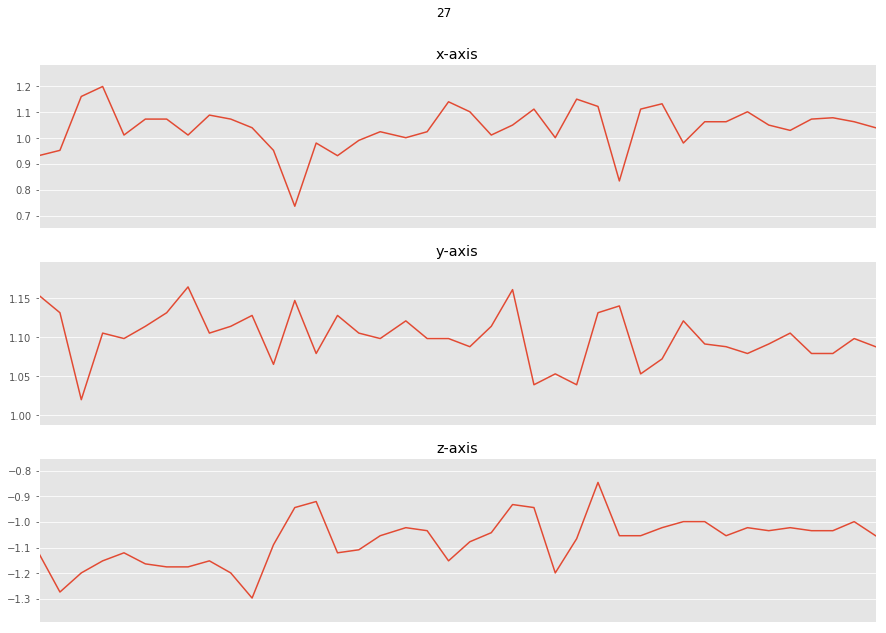

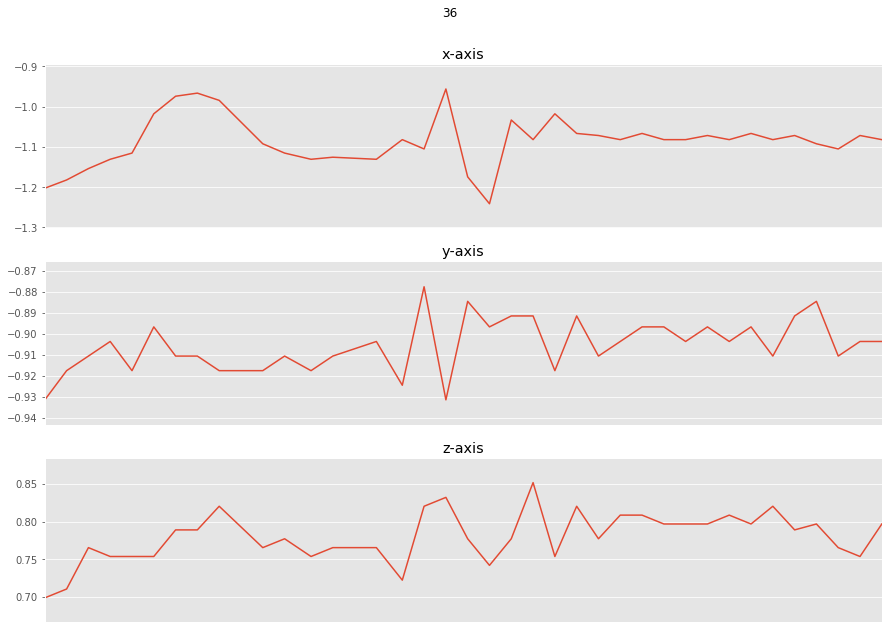

In [7]:
#modify taerget(user-id)
for subject in np.unique(dataset["user-id"]):
    subset = dataset[dataset["user-id"] == subject][:40]
    plot_subject(subject,subset)

In [8]:
segments, labels = segment_signal(dataset)
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
reshaped_segments = segments.reshape(len(segments), 1,90, 3)

In [9]:
train_test_split = np.random.rand(len(reshaped_segments)) < 0.70

train_xi = reshaped_segments[train_test_split]
train_yi = labels[train_test_split]
test_xi = reshaped_segments[~train_test_split]
test_yi = labels[~train_test_split]

In [10]:
#saved data
np.save('train_xi.npy',train_xi)
np.save('train_yi.npy',train_yi)
np.save('test_xi.npy',test_xi)
np.save('test_yi.npy',test_yi)

In [11]:
import numpy as np
train_xi = np.load('train_xi.npy')
train_yi = np.load('train_yi.npy')
test_xi = np.load('test_xi.npy')
test_yi = np.load('test_yi.npy')

In [12]:
#sitting label
input_height = 1
input_width = 90
num_labels = 2 #number of users
num_channels = 3

batch_size = 128
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 2000

total_batches = train_xi.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_yu.shape[0] - batch_size)
            batch_x = train_xi[offset:(offset + batch_size), :, :, :]
            batch_y = train_yi[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_xi, Y: train_yi}))
        with tf.name_scope('summary'):
            tf.summary.scalar('loss', loss)
            merged = tf.summary.merge_all()
            writer = tf.summary.FileWriter('./logs', session.graph)
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_xi, Y: test_yi}))

Epoch:  0  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  2  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  3  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  4  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  5  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  6  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  7  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  8  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Tra

Epoch:  72  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  73  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  74  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  75  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  76  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  77  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  78  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  79  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  80  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=floa

Epoch:  143  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  144  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  145  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  146  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  147  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  148  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  149  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  150  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  151  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), d

Epoch:  214  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  215  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  216  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  217  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  218  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  219  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  220  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  221  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  222  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), d

Epoch:  285  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  286  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  287  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  288  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  289  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  290  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  291  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  292  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  293  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), d

Epoch:  356  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  357  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  358  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  359  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  360  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  361  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  362  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  363  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  364  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), d

Epoch:  427  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  428  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  429  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  430  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  431  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  432  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  433  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  434  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  435  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), d

Epoch:  498  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  499  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  500  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  501  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  502  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  503  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  504  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  505  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  506  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), d

Epoch:  569  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  570  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  571  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  572  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  573  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  574  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  575  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  576  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  577  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), d

Epoch:  640  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  641  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  642  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  643  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  644  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  645  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  646  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  647  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  648  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), d

Epoch:  711  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  712  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  713  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  714  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  715  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  716  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  717  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  718  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  719  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), d

Epoch:  782  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  783  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  784  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  785  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  786  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  787  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  788  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  789  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  790  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), d

Epoch:  853  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  854  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  855  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  856  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  857  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  858  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  859  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  860  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  861  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), d

Epoch:  924  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  925  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  926  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  927  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  928  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  929  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  930  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  931  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  932  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), d

Epoch:  995  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  996  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  997  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  998  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  999  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1000  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1001  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1002  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1003  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080

Epoch:  1066  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1067  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1068  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1069  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1070  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1071  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1072  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1073  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1074  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1,

Epoch:  1137  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1138  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1139  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1140  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1141  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1142  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1143  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1144  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1145  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1,

Epoch:  1208  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1209  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1210  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1211  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1212  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1213  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1214  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1215  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1216  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1,

Epoch:  1279  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1280  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1281  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1282  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1283  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1284  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1285  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1286  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1287  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1,

Epoch:  1350  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1351  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1352  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1353  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1354  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1355  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1356  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1357  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1358  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1,

Epoch:  1421  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1422  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1423  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1424  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1425  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1426  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1427  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1428  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1429  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1,

Epoch:  1492  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1493  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1494  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1495  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1496  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1497  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1498  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1499  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1500  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1,

Epoch:  1563  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1564  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1565  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1566  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1567  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1568  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1569  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1570  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1571  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1,

Epoch:  1634  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1635  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1636  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1637  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1638  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1639  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1640  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1641  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1642  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1,

Epoch:  1705  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1706  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1707  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1708  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1709  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1710  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1711  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1712  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1713  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1,

Epoch:  1776  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1777  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1778  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1779  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1780  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1781  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1782  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1783  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1784  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1,

Epoch:  1847  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1848  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1849  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1850  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1851  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1852  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1853  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1854  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1855  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1,

Epoch:  1918  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1919  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1920  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1921  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1922  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1923  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1924  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1925  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1926  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1,

Epoch:  1989  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1990  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1991  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1992  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1993  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1994  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1995  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1996  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1, 1080), dtype=float32)  Training Accuracy:  0.478261
Epoch:  1997  Training Loss:  Tensor("Relu_1:0", shape=(?, 1, 1,

In [13]:
batch_x.shape

NameError: name 'batch_x' is not defined

In [ ]:
batch_y.shape

In [ ]:
#upstairs label
input_height = 1
input_width = 90
num_labels = 10 #number of users
num_channels = 3

batch_size = 32
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 1000

total_batches = train_xj.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_yj.shape[0] - batch_size)
            batch_x = train_xj[offset:(offset + batch_size), :, :, :]
            batch_y = train_yj[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_xj, Y: train_yj}))
        with tf.name_scope('summary'):
            tf.summary.scalar('loss', loss)
            merged = tf.summary.merge_all()
            writer = tf.summary.FileWriter('./logs', session.graph)
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_xj, Y: test_yj}))

In [ ]:
#upstairs label
input_height = 1
input_width = 90
num_labels = 10 #number of users
num_channels = 3

batch_size = 128
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 2000

total_batches = train_xj.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_yj.shape[0] - batch_size)
            batch_x = train_xj[offset:(offset + batch_size), :, :, :]
            batch_y = train_yj[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_xj, Y: train_yj}))
        with tf.name_scope('summary'):
            tf.summary.scalar('loss', loss)
            merged = tf.summary.merge_all()
            writer = tf.summary.FileWriter('./logs', session.graph)
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_xj, Y: test_yj}))